# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from datetime import datetime, timedelta
import matplotlib.dates as mdates
import pytz

# Load Data

In [2]:
df_hebrew_sentiment = pd.read_csv("../data/sentiment/df_hebrew_sentiment_dictabert.csv")
df_arabic_sentiment = pd.read_csv("../data/sentiment/df_arabic_sentiment.csv")

C:\Users\user\AppData\Local\Temp\ipykernel_34444\2484302013.py:2: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df_arabic_sentiment = pd.read_csv("../data/sentiment/df_arabic_sentiment.csv")


In [3]:
# Fix the timezone relationship between utc_date and local_date
for df in [df_hebrew_sentiment, df_arabic_sentiment]:
    # Ensure utc_date is properly set as UTC
    if not pd.api.types.is_datetime64_any_dtype(df['utc_date']):
        df['utc_date'] = pd.to_datetime(df['utc_date'], utc=True)
    elif df['utc_date'].dt.tz is None:
        df['utc_date'] = df['utc_date'].dt.tz_localize('UTC')

    # Now correctly derive local_date from utc_date
    israel_tz = pytz.timezone('Asia/Jerusalem')
    df['local_date'] = df['utc_date'].dt.tz_convert(israel_tz)

    # Check a sample to verify correction
    if len(df) > 0:
        sample = df.iloc[0]
        print(f"Sample conversion: {sample['utc_date']} (UTC) -> {sample['local_date']} (Israel)")

Sample conversion: 2025-02-21 19:35:05+00:00 (UTC) -> 2025-02-21 21:35:05+02:00 (Israel)
Sample conversion: 2024-11-14 08:57:01+00:00 (UTC) -> 2024-11-14 10:57:01+02:00 (Israel)


# Sentiment Aggregation by Time

**Summary of Sentiment Aggregation by Time:**

We've aggregated sentiment data across different time intervals (hourly, daily, weekly) for both Hebrew and Arabic Telegram messages. Our analysis includes:

- Sentiment distribution trends showing how the percentage of positive, neutral, and negative messages changes over time
- Sentiment index (calculated as (positive - negative) / total messages * 100) to provide a single metric that summarizes sentiment
- Net sentiment (positive % - negative %) as another summary metric
- Message volume patterns to identify activity peaks and correlate with sentiment changes
- Temporal patterns by hour of day and day of week to identify cyclical trends with Sunday as the first day of the week
- Confidence metrics to measure how confident the sentiment classifier is in its predictions



In [4]:
# Check the earliest dates in the original data
print("Earliest Hebrew records:")
earliest_hebrew = df_hebrew_sentiment.sort_values('local_date').head(3)
print(earliest_hebrew[['utc_date', 'local_date']])

print("\nEarliest Arabic records:")
earliest_arabic = df_arabic_sentiment.sort_values('local_date').head(3)
print(earliest_arabic[['utc_date', 'local_date']])

Earliest Hebrew records:
                       utc_date                local_date
82520 2023-10-05 21:00:10+00:00 2023-10-06 00:00:10+03:00
38829 2023-10-05 21:02:30+00:00 2023-10-06 00:02:30+03:00
82519 2023-10-05 21:06:56+00:00 2023-10-06 00:06:56+03:00

Earliest Arabic records:
                        utc_date                local_date
201233 2023-10-05 21:05:22+00:00 2023-10-06 00:05:22+03:00
201232 2023-10-05 21:05:41+00:00 2023-10-06 00:05:41+03:00
345117 2023-10-05 21:20:05+00:00 2023-10-06 00:20:05+03:00


In [5]:
def aggregate_sentiment_by_time(df, date_column='local_date', time_freq='D',
                                group_by_cols=None):
    """
    Aggregate sentiment metrics by specified time frequency with timezone handling.

    Parameters:
    -----------
    df : pandas DataFrame
        DataFrame containing sentiment data
    date_column : str
        Column name for the date to use for aggregation (should be timezone-aware)
    time_freq : str
        Time frequency for aggregation ('h' for hourly, 'D' for daily, 'W' for weekly)
    group_by_cols : list
        Additional columns to group by (e.g., 'type', 'group_name')

    Returns:
    --------
    pandas DataFrame with aggregated sentiment metrics
    """
    # Create a copy to avoid modifying the original
    df_copy = df.copy()

    # Extract date components to avoid timezone operations directly
    df_copy['year'] = df_copy[date_column].dt.year
    df_copy['month'] = df_copy[date_column].dt.month
    df_copy['day'] = df_copy[date_column].dt.day

    # For hourly, include hour information
    if time_freq == 'h':
        df_copy['hour'] = df_copy[date_column].dt.hour
        # Create the time period as a naive datetime
        df_copy['time_period'] = pd.to_datetime(
            df_copy['year'].astype(str) + '-' +
            df_copy['month'].astype(str).str.zfill(2) + '-' +
            df_copy['day'].astype(str).str.zfill(2) + ' ' +
            df_copy['hour'].astype(str).str.zfill(2) + ':00:00'
        )
        period_name = 'hour'
    elif time_freq == 'D':
        # For daily, create date only
        df_copy['time_period'] = pd.to_datetime(
            df_copy['year'].astype(str) + '-' +
            df_copy['month'].astype(str).str.zfill(2) + '-' +
            df_copy['day'].astype(str).str.zfill(2)
        )
        period_name = 'day'
    elif time_freq == 'W':
        # First convert to regular datetime to avoid timezone operations
        dates = pd.to_datetime(
            df_copy['year'].astype(str) + '-' +
            df_copy['month'].astype(str).str.zfill(2) + '-' +
            df_copy['day'].astype(str).str.zfill(2)
        )

        # Get day of week (0=Monday, 6=Sunday in pandas)
        day_of_week = dates.dt.dayofweek

        # Calculate days to subtract to get to Sunday (first day of week)
        days_to_subtract = (day_of_week + 1) % 7

        # Subtract the days to get to the start of the week
        df_copy['time_period'] = dates - pd.to_timedelta(days_to_subtract, unit='D')
        period_name = 'week'
    else:
        raise ValueError("time_freq must be one of 'h', 'D', or 'W'")

    # Ensure sentiment_label is properly formatted
    df_copy['sentiment_label'] = df_copy['sentiment_label'].str.capitalize()

    # Setup groupby columns
    groupby_cols = ['time_period']
    if group_by_cols:
        groupby_cols.extend(group_by_cols)

    # Count messages by sentiment category
    sentiment_counts = df_copy.groupby(groupby_cols + ['sentiment_label'])['message_id'].count().unstack(fill_value=0)

    # Ensure all sentiment categories exist
    for category in ['Positive', 'Neutral', 'Negative']:
        if category not in sentiment_counts.columns:
            sentiment_counts[category] = 0

    # Total message count
    message_counts = df_copy.groupby(groupby_cols)['message_id'].count().to_frame('message_volume')

    # Average confidence score
    confidence_stats = df_copy.groupby(groupby_cols)['sentiment_score'].agg(['mean', 'std']).rename(
        columns={'mean': 'avg_confidence', 'std': 'confidence_volatility'})

    # Combine all metrics
    agg_df = message_counts.join(sentiment_counts).join(confidence_stats)

    # Calculate percentages
    for category in ['Positive', 'Neutral', 'Negative']:
        agg_df[f'pct_{category.lower()}'] = 100 * agg_df[category] / agg_df['message_volume']

    # Calculate a net sentiment score (% positive - % negative)
    agg_df['net_sentiment'] = agg_df['pct_positive'] - agg_df['pct_negative']

    # Calculate a sentiment index (scaled from -100 to +100)
    agg_df['sentiment_index'] = ((agg_df['Positive'] - agg_df['Negative']) /
                               (agg_df['Positive'] + agg_df['Negative'] + agg_df['Neutral'])) * 100

    # Reset index for easier handling
    agg_df = agg_df.reset_index()

    # Add time-related columns for easier analysis
    if time_freq == 'h':
        agg_df['hour_of_day'] = agg_df['time_period'].dt.hour
        agg_df['day_of_week'] = agg_df['time_period'].dt.day_name()

    agg_df['period_type'] = period_name

    return agg_df

In [6]:
# Create time aggregations for Hebrew sentiment
hebrew_hourly = aggregate_sentiment_by_time(df_hebrew_sentiment, time_freq='h')
hebrew_daily = aggregate_sentiment_by_time(df_hebrew_sentiment, time_freq='D')
hebrew_weekly = aggregate_sentiment_by_time(df_hebrew_sentiment, time_freq='W')

# Create time aggregations for Arabic sentiment
arabic_hourly = aggregate_sentiment_by_time(df_arabic_sentiment, time_freq='h')
arabic_daily = aggregate_sentiment_by_time(df_arabic_sentiment, time_freq='D')
arabic_weekly = aggregate_sentiment_by_time(df_arabic_sentiment, time_freq='W')

# Check the earliest dates in the aggregated data
print("\nEarliest aggregated Hebrew daily data:")
print(hebrew_daily.sort_values('time_period').head(1)[['time_period', 'message_volume']])

print("\nEarliest aggregated Arabic daily data:")
print(arabic_daily.sort_values('time_period').head(1)[['time_period', 'message_volume']])


Earliest aggregated Hebrew daily data:
  time_period  message_volume
0  2023-10-06             101

Earliest aggregated Arabic daily data:
  time_period  message_volume
0  2023-10-06             382


In [7]:
def plot_sentiment_over_time(hebrew_df, arabic_df, metric='sentiment_index',
                            title_suffix='', figsize=(14, 8)):
    """
    Create a comparative plot of sentiment metrics for Hebrew and Arabic

    Parameters:
    -----------
    hebrew_df : pandas DataFrame
        Aggregated Hebrew sentiment data
    arabic_df : pandas DataFrame
        Aggregated Arabic sentiment data
    metric : str
        The metric to plot (e.g., 'sentiment_index', 'net_sentiment', 'pct_positive')
    title_suffix : str
        Additional text for the plot title
    figsize : tuple
        Figure size
    """
    fig, ax = plt.subplots(figsize=figsize)

    # Plot Hebrew sentiment
    ax.plot(hebrew_df['time_period'], hebrew_df[metric],
            label='Hebrew', color='blue', marker='o', markersize=4, alpha=0.7)

    # Plot Arabic sentiment
    ax.plot(arabic_df['time_period'], arabic_df[metric],
            label='Arabic', color='green', marker='s', markersize=4, alpha=0.7)

    # Add horizontal line at zero for reference
    ax.axhline(y=0, color='gray', linestyle='-', alpha=0.3)

    # Customize plot
    ax.set_title(f'{metric.replace("_", " ").title()} Over Time {title_suffix}', fontsize=16)
    ax.set_xlabel('Time', fontsize=12)
    ax.set_ylabel(metric.replace('_', ' ').title(), fontsize=12)
    ax.legend(fontsize=12)
    ax.grid(True, alpha=0.3)

    # Format x-axis dates based on frequency
    if len(hebrew_df) > 100:  # For hourly data
        ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    elif len(hebrew_df) > 30:  # For daily data
        ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    else:  # For weekly data
        ax.xaxis.set_major_locator(mdates.MonthLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

    plt.xticks(rotation=45)
    plt.tight_layout()

    return fig, ax

# Create interactive plots with Plotly for better exploration
def create_interactive_sentiment_plot(hebrew_df, arabic_df, metric='sentiment_index',
                                     title_suffix=''):
    """
    Create an interactive plot using Plotly for sentiment comparison
    """
    fig = go.Figure()

    # Add Hebrew sentiment trace
    fig.add_trace(go.Scatter(
        x=hebrew_df['time_period'],
        y=hebrew_df[metric],
        mode='lines+markers',
        name='Hebrew',
        line=dict(color='blue'),
        marker=dict(size=6),
        hovertemplate='%{x}<br>Value: %{y:.2f}<br>Messages: %{text}<extra></extra>',
        text=hebrew_df['message_volume']
    ))

    # Add Arabic sentiment trace
    fig.add_trace(go.Scatter(
        x=arabic_df['time_period'],
        y=arabic_df[metric],
        mode='lines+markers',
        name='Arabic',
        line=dict(color='green'),
        marker=dict(size=6),
        hovertemplate='%{x}<br>Value: %{y:.2f}<br>Messages: %{text}<extra></extra>',
        text=arabic_df['message_volume']
    ))

    # Add a horizontal reference line at zero
    fig.add_shape(
        type='line',
        x0=hebrew_df['time_period'].min(),
        y0=0,
        x1=hebrew_df['time_period'].max(),
        y1=0,
        line=dict(color='gray', width=1, dash='dash')
    )

    # Update layout
    fig.update_layout(
        title=f'{metric.replace("_", " ").title()} Over Time {title_suffix}',
        xaxis_title='Time',
        yaxis_title=metric.replace('_', ' ').title(),
        hovermode='closest',
        legend=dict(orientation='h', yanchor='bottom', y=1.02, xanchor='right', x=1),
        height=600,
        template='plotly_white'
    )

    return fig

## sentiment trend plots

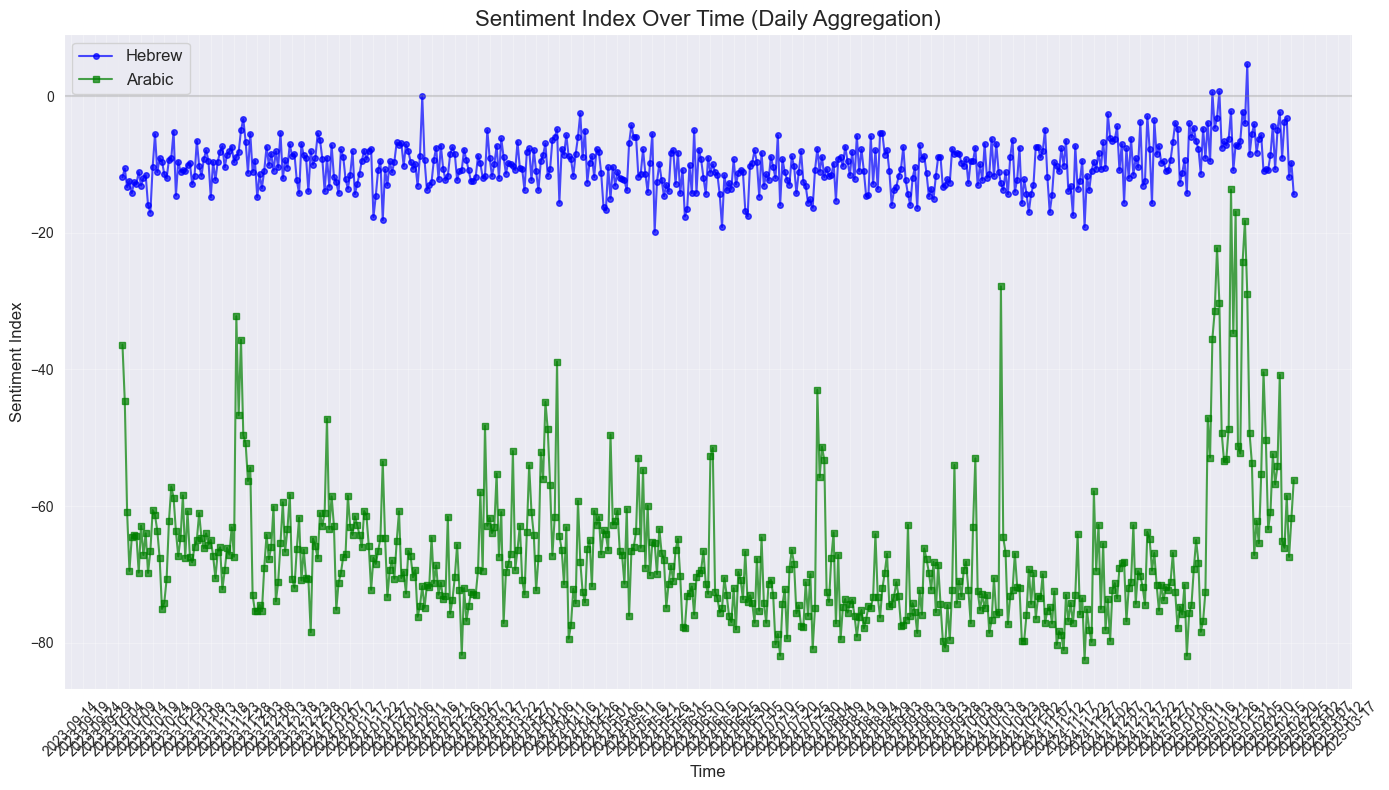

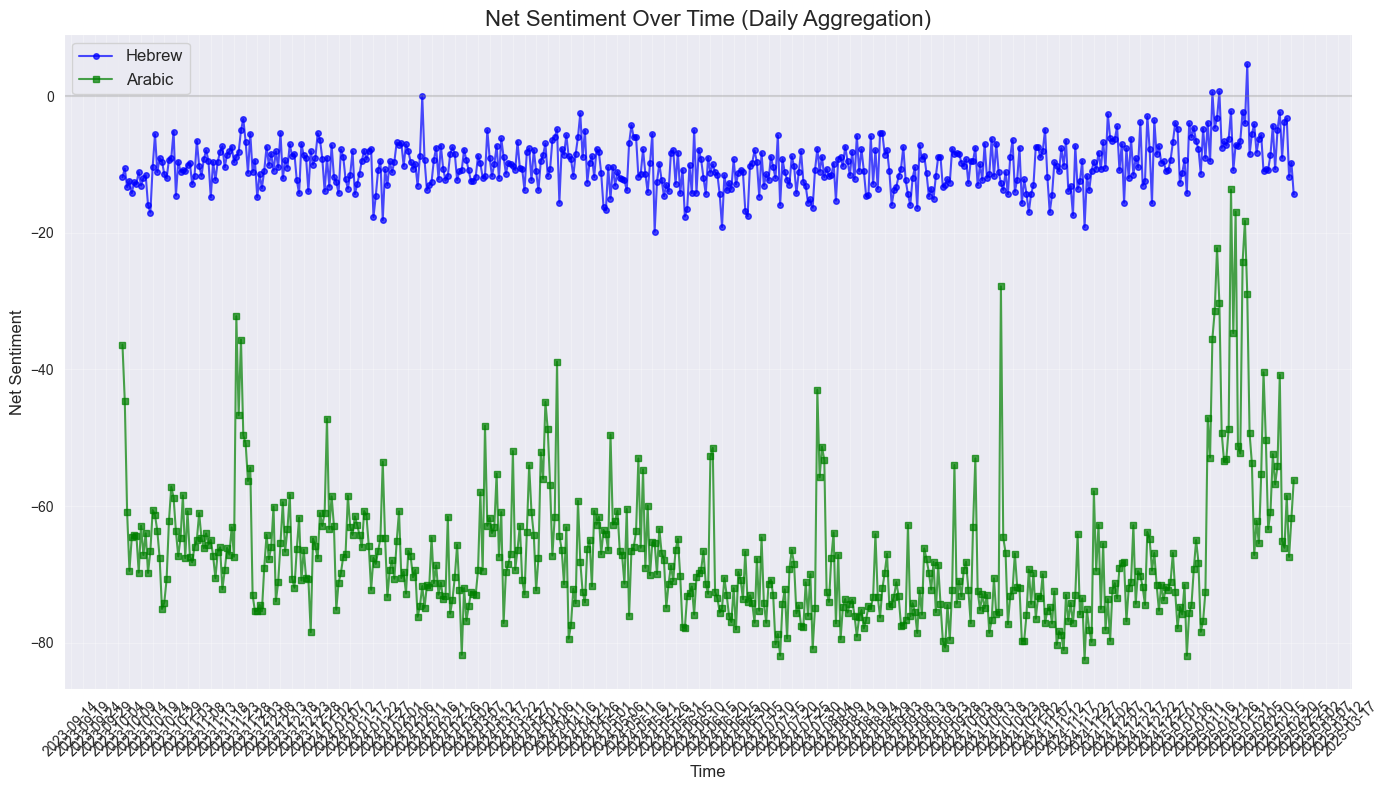

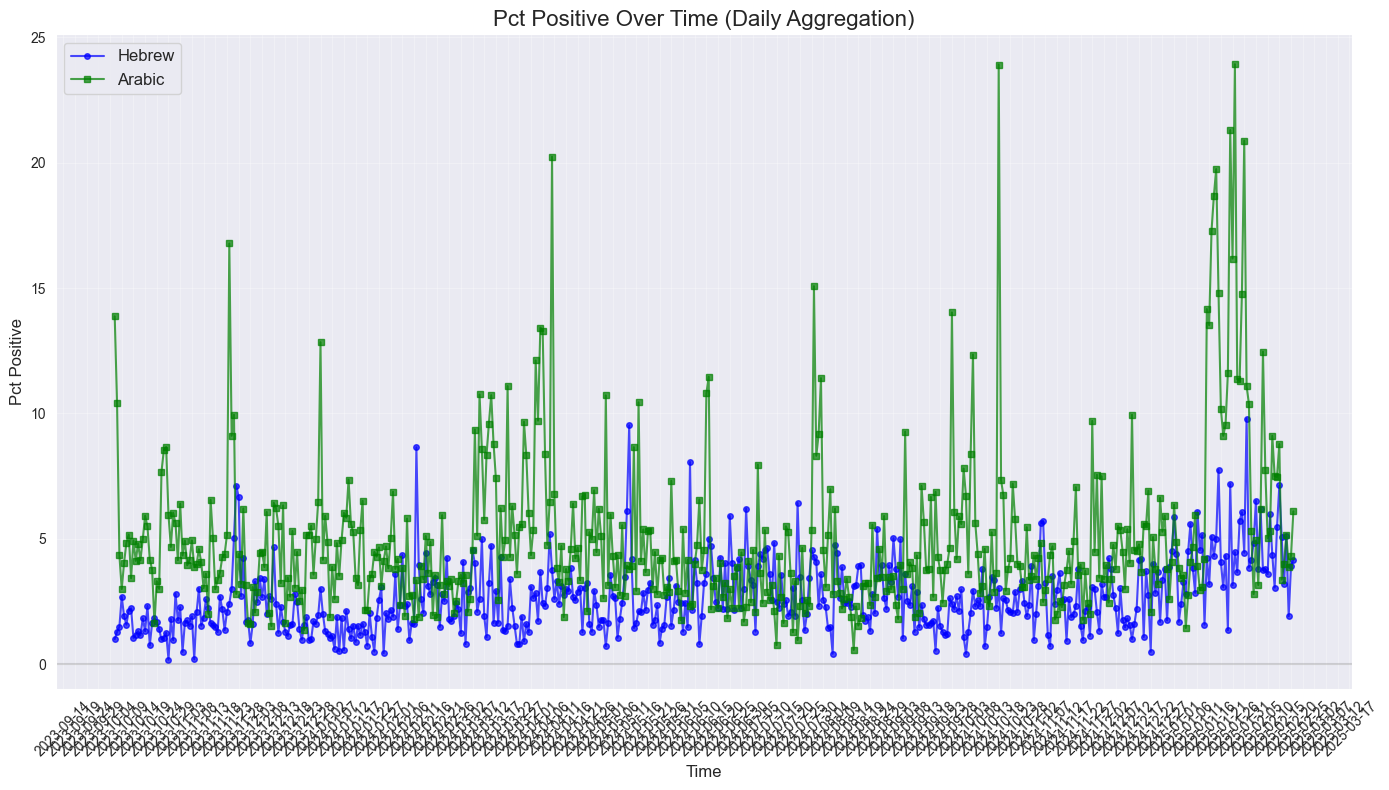

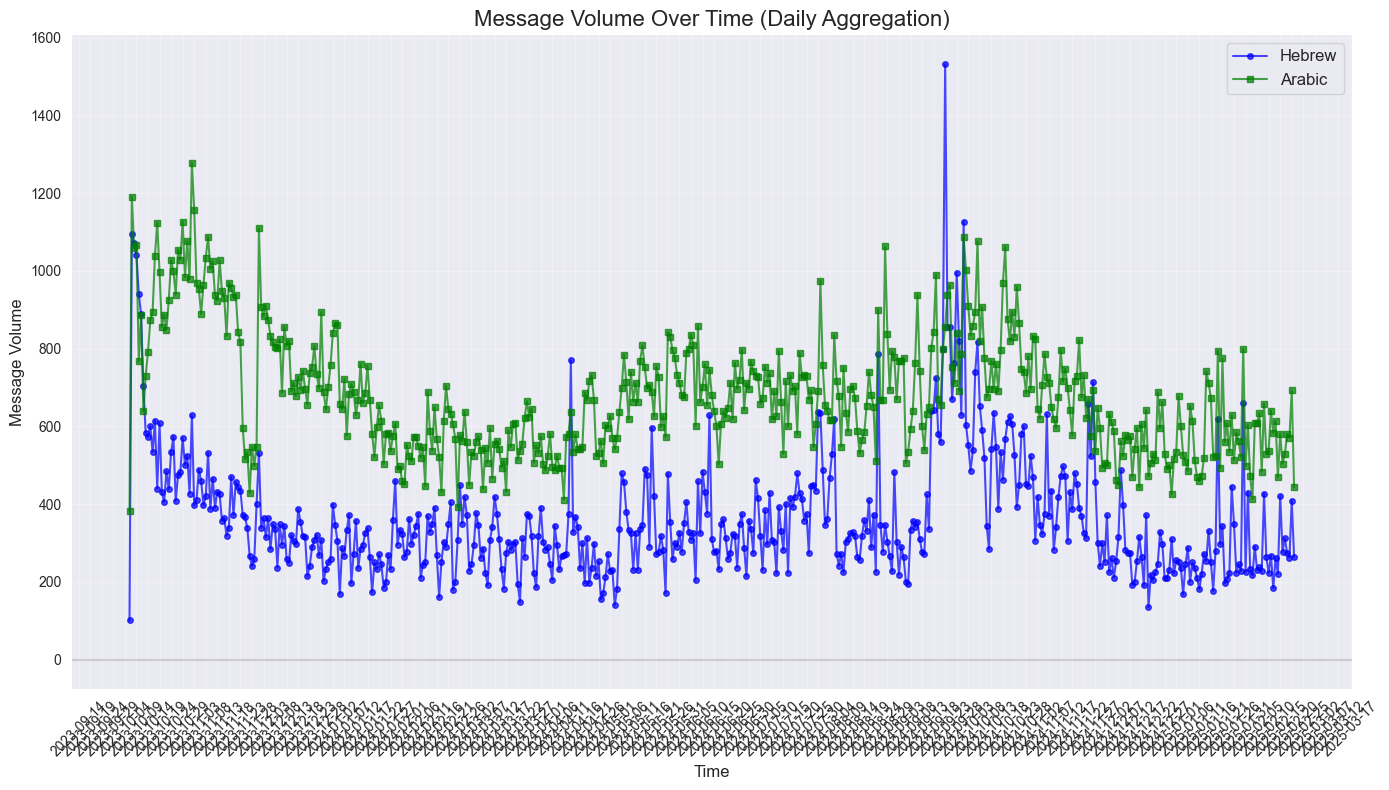

In [8]:
# Create static plots
fig_daily, ax_daily = plot_sentiment_over_time(hebrew_daily, arabic_daily,
                                              title_suffix='(Daily Aggregation)')

# # Create interactive plots
# fig_daily_interactive = create_interactive_sentiment_plot(hebrew_daily, arabic_daily,
#                                                         title_suffix='(Daily Aggregation)')
# fig_daily_interactive.show()

# Plot net sentiment
fig_net, ax_net = plot_sentiment_over_time(hebrew_daily, arabic_daily,
                                         metric='net_sentiment',
                                         title_suffix='(Daily Aggregation)')

# Plot positive percentage
fig_positive, ax_positive = plot_sentiment_over_time(hebrew_daily, arabic_daily,
                                                   metric='pct_positive',
                                                   title_suffix='(Daily Aggregation)')

# Plot message volume
fig_volume, ax_volume = plot_sentiment_over_time(hebrew_daily, arabic_daily,
                                               metric='message_volume',
                                               title_suffix='(Daily Aggregation)')

## sentiment distribution visualization

In [9]:
def plot_sentiment_distribution_over_time(df, language, time_freq='daily'):
    """
    Create a stacked area chart showing the distribution of positive, neutral,
    and negative sentiment over time
    """
    fig = go.Figure()

    # Add traces for positive, neutral, and negative percentages
    fig.add_trace(go.Scatter(
        x=df['time_period'],
        y=df['pct_positive'],
        mode='lines',
        stackgroup='one',
        name='Positive',
        line=dict(width=0.5, color='green'),
        hovertemplate='%{x}<br>Positive: %{y:.1f}%<extra></extra>'
    ))

    fig.add_trace(go.Scatter(
        x=df['time_period'],
        y=df['pct_neutral'],
        mode='lines',
        stackgroup='one',
        name='Neutral',
        line=dict(width=0.5, color='gray'),
        hovertemplate='%{x}<br>Neutral: %{y:.1f}%<extra></extra>'
    ))

    fig.add_trace(go.Scatter(
        x=df['time_period'],
        y=df['pct_negative'],
        mode='lines',
        stackgroup='one',
        name='Negative',
        line=dict(width=0.5, color='red'),
        hovertemplate='%{x}<br>Negative: %{y:.1f}%<extra></extra>'
    ))

    # Update layout
    fig.update_layout(
        title=f'{language} Sentiment Distribution Over Time ({time_freq})',
        xaxis_title='Time',
        yaxis_title='Percentage (%)',
        yaxis=dict(range=[0, 100]),
        hovermode='closest',
        legend=dict(orientation='h', yanchor='bottom', y=1.02, xanchor='right', x=1),
        height=500,
        template='plotly_white'
    )

    return fig

In [ ]:
# Create sentiment distribution plots
hebrew_dist_plot = plot_sentiment_distribution_over_time(hebrew_daily, 'Hebrew', 'Daily')
hebrew_dist_plot.show()

arabic_dist_plot = plot_sentiment_distribution_over_time(arabic_daily, 'Arabic', 'Daily')
arabic_dist_plot.show()

## side-by-side comparison

### interactive

In [11]:
def create_side_by_side_comparison(hebrew_df, arabic_df):
    """
    Create a side-by-side comparison of Hebrew and Arabic sentiment metrics
    """
    fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=(
            'Sentiment Index',
            'Message Volume',
            'Positive Sentiment %',
            'Negative Sentiment %'
        ),
        shared_xaxes=True
    )

    # Sentiment index
    fig.add_trace(
        go.Scatter(x=hebrew_df['time_period'], y=hebrew_df['sentiment_index'],
                  name='Hebrew', line=dict(color='blue')),
        row=1, col=1
    )
    fig.add_trace(
        go.Scatter(x=arabic_df['time_period'], y=arabic_df['sentiment_index'],
                  name='Arabic', line=dict(color='green')),
        row=1, col=1
    )

    # Message volume
    fig.add_trace(
        go.Scatter(x=hebrew_df['time_period'], y=hebrew_df['message_volume'],
                  name='Hebrew', line=dict(color='blue'), showlegend=False),
        row=1, col=2
    )
    fig.add_trace(
        go.Scatter(x=arabic_df['time_period'], y=arabic_df['message_volume'],
                  name='Arabic', line=dict(color='green'), showlegend=False),
        row=1, col=2
    )

    # Positive percentage
    fig.add_trace(
        go.Scatter(x=hebrew_df['time_period'], y=hebrew_df['pct_positive'],
                  name='Hebrew', line=dict(color='blue'), showlegend=False),
        row=2, col=1
    )
    fig.add_trace(
        go.Scatter(x=arabic_df['time_period'], y=arabic_df['pct_positive'],
                  name='Arabic', line=dict(color='green'), showlegend=False),
        row=2, col=1
    )

    # Negative percentage
    fig.add_trace(
        go.Scatter(x=hebrew_df['time_period'], y=hebrew_df['pct_negative'],
                  name='Hebrew', line=dict(color='blue'), showlegend=False),
        row=2, col=2
    )
    fig.add_trace(
        go.Scatter(x=arabic_df['time_period'], y=arabic_df['pct_negative'],
                  name='Arabic', line=dict(color='green'), showlegend=False),
        row=2, col=2
    )

    # Update layout
    fig.update_layout(
        title='Hebrew vs Arabic Sentiment Metrics Comparison',
        height=800,
        legend=dict(orientation='h', yanchor='bottom', y=1.02, xanchor='right', x=1),
        template='plotly_white'
    )

    # Add zero reference lines to the sentiment index plot
    fig.add_shape(
        type='line', x0=hebrew_df['time_period'].min(), y0=0,
        x1=hebrew_df['time_period'].max(), y1=0,
        line=dict(color='gray', width=1, dash='dash'),
        row=1, col=1
    )

    return fig

In [13]:
# Create the side-by-side comparison
comparison_plot = create_side_by_side_comparison(hebrew_daily, arabic_daily)
comparison_plot.show()

### regular static plot

In [23]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

def create_side_by_side_comparison_static(hebrew_df, arabic_df, output_path='sentiment_comparison.pdf'):
    """
    Create a static side-by-side comparison of Hebrew and Arabic sentiment metrics
    showing only sentiment index and message volume, and save as PDF
    """
    # Create figure with just 2 subplots (1 row, 2 columns)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    # Sentiment index
    ax1.plot(hebrew_df['time_period'], hebrew_df['sentiment_index'], 'b-', label='Hebrew')
    ax1.plot(arabic_df['time_period'], arabic_df['sentiment_index'], 'g-', label='Arabic')
    ax1.axhline(y=0, color='gray', linestyle='--', alpha=0.7)  # Zero reference line
    ax1.set_title('Sentiment Index')
    ax1.legend()

    # Message volume
    ax2.plot(hebrew_df['time_period'], hebrew_df['message_volume'], 'b-', label='Hebrew')
    ax2.plot(arabic_df['time_period'], arabic_df['message_volume'], 'g-', label='Arabic')
    ax2.set_title('Message Volume')

    # Format dates on x-axis if needed
    for ax in [ax1, ax2]:
        if len(hebrew_df) > 0 and isinstance(hebrew_df['time_period'].iloc[0], np.datetime64):
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
            ax.xaxis.set_major_locator(mdates.AutoDateLocator())
            plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

    # Add overall title and adjust layout
    # plt.suptitle('Hebrew vs Arabic Sentiment Metrics Comparison', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust to make room for suptitle

    # Save the figure as PDF
    plt.savefig(output_path, format='pdf', bbox_inches='tight', dpi=300)
    print(f"Figure saved as {output_path}")

    return fig

# Example usage:
# create_side_by_side_comparison_static(hebrew_df, arabic_df, 'sentiment_analysis.pdf')

Figure saved as ../figs/sentiment_agg_side_by_side_comparison.pdf


C:\Users\user\AppData\Local\Temp\ipykernel_34444\4085771954.py:3: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



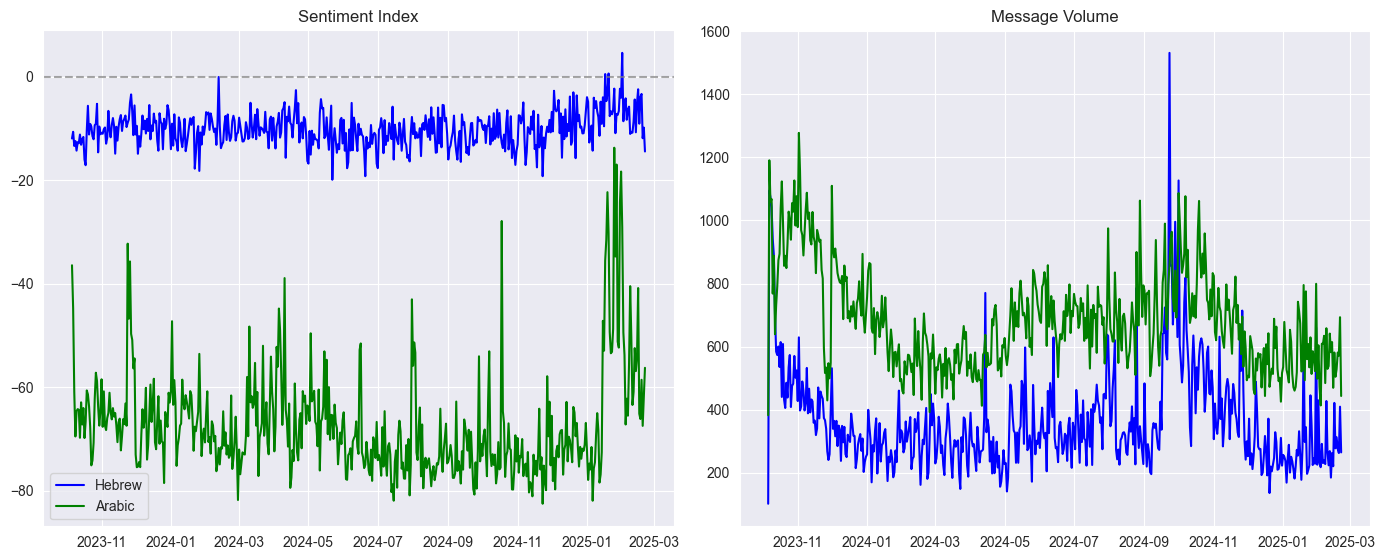

In [24]:
# Create the side-by-side comparison
comparison_plot_static = create_side_by_side_comparison_static(hebrew_daily, arabic_daily, "../figs/sentiment_agg_side_by_side_comparison.pdf")
comparison_plot_static.show()

## temporal patterns analysis

In [15]:
def analyze_temporal_patterns(hourly_df, language):
    """
    Analyze sentiment patterns by hour of day and day of week
    """
    # Create hour of day pattern dataframe
    hour_pattern = hourly_df.groupby('hour_of_day').agg({
        'sentiment_index': 'mean',
        'message_volume': 'sum',
        'pct_positive': 'mean',
        'pct_negative': 'mean',
        'avg_confidence': 'mean'
    }).reset_index()

    # Create day of week pattern dataframe
    # Order days with Sunday first
    day_order = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
    day_pattern = hourly_df.groupby('day_of_week').agg({
        'sentiment_index': 'mean',
        'message_volume': 'sum',
        'pct_positive': 'mean',
        'pct_negative': 'mean',
        'avg_confidence': 'mean'
    }).reset_index()

    # Ensure proper ordering of days
    day_pattern['day_order'] = day_pattern['day_of_week'].map(lambda x: day_order.index(x))
    day_pattern = day_pattern.sort_values('day_order')

    # Create hour of day plot
    fig_hour = go.Figure()

    fig_hour.add_trace(go.Bar(
        x=hour_pattern['hour_of_day'],
        y=hour_pattern['message_volume'],
        name='Message Volume',
        marker_color='lightblue',
        opacity=0.7,
        yaxis='y2'
    ))

    fig_hour.add_trace(go.Scatter(
        x=hour_pattern['hour_of_day'],
        y=hour_pattern['sentiment_index'],
        name='Sentiment Index',
        mode='lines+markers',
        line=dict(color='darkblue', width=2),
        marker=dict(size=8)
    ))

    fig_hour.update_layout(
        title=f'{language} Sentiment by Hour of Day',
        xaxis=dict(title='Hour of Day (24h)', tickmode='linear', dtick=2),
        yaxis=dict(title='Sentiment Index', side='left'),
        yaxis2=dict(title='Message Volume', side='right', overlaying='y', showgrid=False),
        hovermode='x unified',
        legend=dict(orientation='h', yanchor='bottom', y=1.02, xanchor='right', x=1),
        template='plotly_white'
    )

    # Create day of week plot
    fig_day = go.Figure()

    fig_day.add_trace(go.Bar(
        x=day_pattern['day_of_week'],
        y=day_pattern['message_volume'],
        name='Message Volume',
        marker_color='lightblue',
        opacity=0.7,
        yaxis='y2'
    ))

    fig_day.add_trace(go.Scatter(
        x=day_pattern['day_of_week'],
        y=day_pattern['sentiment_index'],
        name='Sentiment Index',
        mode='lines+markers',
        line=dict(color='darkblue', width=2),
        marker=dict(size=8)
    ))

    fig_day.update_layout(
        title=f'{language} Sentiment by Day of Week',
        xaxis=dict(title='Day of Week', categoryorder='array', categoryarray=day_order),
        yaxis=dict(title='Sentiment Index', side='left'),
        yaxis2=dict(title='Message Volume', side='right', overlaying='y', showgrid=False),
        hovermode='x unified',
        legend=dict(orientation='h', yanchor='bottom', y=1.02, xanchor='right', x=1),
        template='plotly_white'
    )

    return fig_hour, fig_day, hour_pattern, day_pattern

In [16]:
# Analyze temporal patterns
hebrew_hour_fig, hebrew_day_fig, hebrew_hour_pattern, hebrew_day_pattern = analyze_temporal_patterns(
    hebrew_hourly, 'Hebrew')
arabic_hour_fig, arabic_day_fig, arabic_hour_pattern, arabic_day_pattern = analyze_temporal_patterns(
    arabic_hourly, 'Arabic')

In [17]:
# # Display the plots
# hebrew_hour_fig.show()
# hebrew_day_fig.show()
# arabic_hour_fig.show()
# arabic_day_fig.show()

## save aggregated data for future analysis steps

In [18]:
# Save aggregated data for future analysis steps
hebrew_hourly.to_csv('hebrew_sentiment_hourly.csv', index=False)
hebrew_daily.to_csv('hebrew_sentiment_daily.csv', index=False)
hebrew_weekly.to_csv('hebrew_sentiment_weekly.csv', index=False)

arabic_hourly.to_csv('arabic_sentiment_hourly.csv', index=False)
arabic_daily.to_csv('arabic_sentiment_daily.csv', index=False)
arabic_weekly.to_csv('arabic_sentiment_weekly.csv', index=False)